<p align="center">
<FONT FACE="times new roman" SIZE=5>
<br>
<img src="https://www.usergioarboleda.edu.co/wp-content/uploads/ultimatum/imagens/logo-mobile-UniversidadSergioArboleda.png"
width="750" height="250">
</img>
<br>
<i><b>Docente:</b> Juan Pablo Ospina.</i>
<br>
<i><b>Asignatura:</b> Vida artificial</i>
<br>
<i><b>Estudiantes:</b> Chiara Valenzuela, Andrea Terraza y Miguel Thomas</i>
<br>
<i><b>Tema:</b> Forecasting</i>
<br>
<i><b>Grupo:</b> Dracarys (A)</i>
<br>
<img src='https://i.pinimg.com/originals/ba/78/85/ba788588817b74ef4713383ceac3e0ef.gif'>
<br>
<i>01/10/24</i>
</FONT>
</p>

# Importaciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import plotly.express as px
import pandas as pd
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.style.use('ggplot')

#1. Cargue en un dataframe el archivo global_economy.csv disponible en este repositorio: https://github.com/jpospinalo/time-series

## Lectura de datos

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jpospinalo/time-series/refs/heads/main/global_economy.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)
df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0
2,Afghanistan,AFG,1962,5.466667e+08,NaN,NaN,9.349593,4.878051,9345868.0
3,Afghanistan,AFG,1963,7.511112e+08,NaN,NaN,16.863910,9.171601,9533954.0
4,Afghanistan,AFG,1964,8.000000e+08,NaN,NaN,18.055555,8.888893,9731361.0


## Reemplazo de valores faltantes columna GDP

In [ ]:
df['GDP'].isnull().sum()

3322

In [ ]:
# Reemplzar datos nulos con la media movil
df['GDP_MA'] = df['GDP'].rolling(window=3, min_periods=1).mean()
df['GDP'].fillna(df['GDP_MA'], inplace=True)
df.drop(columns=['GDP_MA'], inplace=True)

In [ ]:
df['GDP'].isnull().sum()

3040

Tras utilizar el metodo de la media movil para reemplazar los valores aun siguen habiendo datos faltantes por lo que se utilizara el metodo de interpolacion lineal para rellenar los datos faltantes.

In [ ]:
# Rellenar datos con interpolacion lineal
df['GDP'].interpolate(method='linear', inplace=True)

#2. Genere una nueva columna llamada GDP_per_capita dividiendo cada uno de los valores de GDP por la población

In [ ]:
# Rellenar datos con interpolacion lineal
df['Population'].interpolate(method='linear', inplace=True)
df['GDP_per_capita'] = df['GDP'] / df['Population']

#3. Genere un nuevo dataframe únicamente con las columnas “Year”, “Country”, “GDP”, “Population” y “GDP_per_capita”

In [ ]:
df_nuevo = df[['Country', 'GDP', 'Population', 'GDP_per_capita','Year']].copy()
df_nuevo.head()

,Country,GDP,Population,GDP_per_capita,Year
0,Afghanistan,5.377778e+08,8996351.0,59.777327,1960
1,Afghanistan,5.488889e+08,9166764.0,59.878153,1961
2,Afghanistan,5.466667e+08,9345868.0,58.492874,1962
3,Afghanistan,7.511112e+08,9533954.0,78.782758,1963
4,Afghanistan,8.000000e+08,9731361.0,82.208444,1964


# 4. Visualice la serie de tiempo para los valores del GDP_per_capita para Suecia

In [ ]:
df_suecia = df_nuevo[df_nuevo['Country'] == 'Sweden']

In [ ]:
# Crear el gráfico de la serie de tiempo
fig = px.line(df_suecia, x=df_suecia['Year'], y='GDP_per_capita',
              title='Serie de tiempo del GDP per capita para Suecia',
              labels={'GDP_per_capita': 'GDP per capita', 'index': 'Año'},
              markers=True)
fig.show()

#5. Consulte en qué consisten los residuales de un modelo de regresión. ¿Qué distribución de probabilidad se asume usualmente para los residuales? Explique la razón.

Los **residuales** de un modelo de regresión son las diferencias entre los valores observados y los valores predichos por el modelo. En términos matemáticos, se definen como:

$$
\text{Residual} = \text{Valor observado} - \text{Valor predicho}
$$

Esto significa que para cada observación en el conjunto de datos, el residual indica cuánto se desvía la predicción del modelo del valor real. Un residual  positivo ($e_i > 0$) sugiere que el modelo subestimó el valor observado, mientras que un residual negativo ($e_i < 0$) indica una sobreestimación [2][5].

La evaluación de los residuales es esencial para medir la precisión de un modelo de regresión, ya que su distribución aleatoria alrededor de cero indica que el modelo es adecuado. Por otro lado, si los residuales presentan patrones o tendencias, puede ser señal de que el modelo no captura correctamente la relación entre las variables. Graficar los residuales facilita la identificación de problemas como la heterocedasticidad, que ocurre cuando la variabilidad de los residuales varía según los valores predichos, o la no linealidad, donde los patrones curvos en los residuales sugieren que un modelo lineal no es el más adecuado. Además, la presencia de outliers, con residuales extremadamente altos o bajos, indica que el modelo no logra explicar ciertos puntos de los datos, Tambien se debe tener en cuenta que en un modelo bien ajustado, la suma de los residuales debería aproximarse a cero, ya que los errores positivos y negativos se compensan entre sí y esto indica un buen modelo.

### Distribución de probabilidad de los residuales

En la mayoría de los modelos de regresión, especialmente en la regresión lineal, se asume que los residuales siguen una **distribución normal**. Esta suposición es fundamental porque permite aplicar inferencias estadísticas y realizar pruebas de hipótesis sobre los parámetros del modelo. La razón principal detrás de esta suposición es el **Teorema del Límite Central**, que establece que la suma (o promedio) de un gran número de variables aleatorias independientes y idénticamente distribuidas tiende a seguir una distribución normal, independientemente de la distribución original de las variables[4][5].

La normalidad de los residuales implica que:

1. **Simetría**: La distribución debe ser simétrica alrededor de cero.
2. **Varianza constante**: La varianza de los residuales debe ser constante a lo largo de todos los niveles de la variable independiente (homocedasticidad).
3. **Independencia**: Los residuales deben ser independientes entre sí[3][5].

La verificación de estas condiciones se puede realizar mediante análisis gráficos, como diagramas residuales, donde se espera que los residuos no muestren patrones claros y estén distribuidos aleatoriamente alrededor de cero[3]. Si estas condiciones no se cumplen, puede ser necesario ajustar el modelo o considerar transformaciones en los datos.

Referencias:
- [1] https://www.ucm.es/data/cont/docs/518-2013-11-13-Analisis%20de%20Regresion.pdf
- [2] https://es.khanacademy.org/math/ap-statistics/bivariate-data-ap/least-squares-regression/v/regression-residual-intro
- [3] https://www.qualtrics.com/support/es/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
- [4] https://www.maximaformacion.es/blog-dat/como-validar-tu-modelo-de-regresion/
- [5] https://www.youtube.com/watch?v=-HPCzYHGhYk
- [6] http://www.hrc.es/bioest/Reglin_16.html
- [7] https://virtual.uptc.edu.co/ova/estadistica/docs/libros/2007315/lecciones_html/capitulo_2/leccion3/residuales.html

# 6. Ajuste un modelo de regresión lineal para los datos de GDP_per_capita en Suecia.

In [ ]:
# Definir la variable dependiente (GDP_per_capita) y la independiente (Year)
X = df_suecia['Year']
y = df_suecia['GDP_per_capita']

# Añadir una constante a la variable independiente (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
modelo = sm.OLS(y, X).fit()

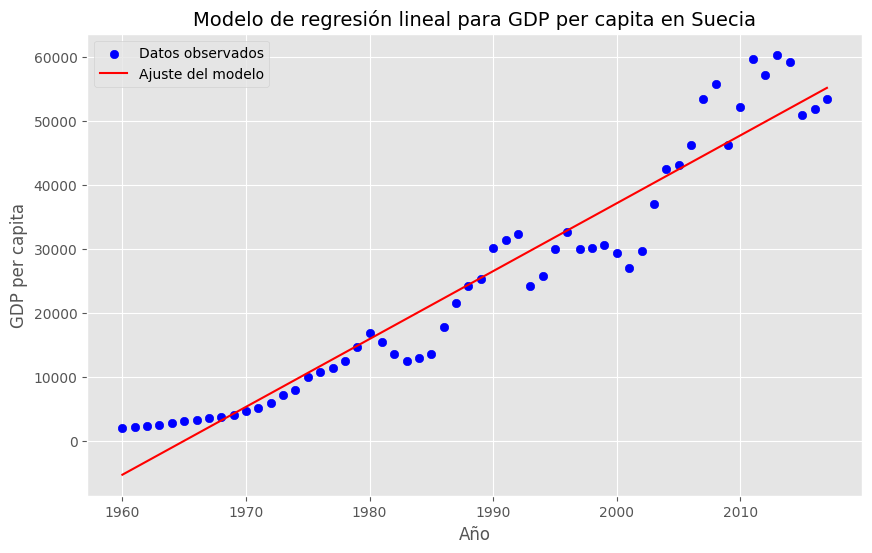

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_suecia['Year'], df_suecia['GDP_per_capita'], label='Datos observados', color='blue')
plt.plot(df_suecia['Year'], modelo.predict(X), label='Ajuste del modelo', color='red')

plt.title('Modelo de regresión lineal para GDP per capita en Suecia', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('GDP per capita', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

# 7. Genere una predicción de GDP_per_capita en Suiza para los próximos 3 años usando la media móvil

In [ ]:
df_suiza = df_nuevo[df_nuevo['Country'] == 'Switzerland'].copy()
df_suiza.sort_values(by='Year', inplace=True)

In [ ]:
# Aplicar la media móvil
df_suiza['GDP_per_capita_MA'] = df_suiza['GDP_per_capita'].rolling(window=3, min_periods=1).mean()

# Obtener la media móvil de los últimos 3 años disponibles para predecir los siguientes 3 años
ultima_ma = df_suiza['GDP_per_capita_MA'].iloc[-1]
anios_futuros = pd.DataFrame({
    'Year': [df_suiza['Year'].max() + i for i in range(1, 4)],
    'GDP_per_capita': [ultima_ma] * 3
})

In [ ]:
# Mostrar las predicciones
print(anios_futuros)

   Year  GDP_per_capita
0  2018    80690.583349
1  2019    80690.583349
2  2020    80690.583349


#8. Visualice los datos reales y los generados en la predicción. ¿El resultado obtenido en la predicción es coherente con los datos? Explique su respuesta

In [ ]:
# Combinar datos históricos con las predicciones
df_prediccion = pd.concat([df_suiza[['Year', 'GDP_per_capita']], anios_futuros])

In [ ]:
fig = px.line(df_prediccion, x='Year', y='GDP_per_capita',
              title='Predicción del GDP per capita en Suiza',
              labels={'GDP_per_capita': 'GDP per capita', 'Year': 'Año'},
              markers=True)


fig.add_scatter(x=anios_futuros['Year'], y=anios_futuros['GDP_per_capita'],
                mode='lines+markers', name='Predicciones', line=dict(dash='dash', color='red'))
fig.show()

La serie de tiempo correspondiente al GDP_per_capita revela una tendencia general alcista, con algunas fluctuaciones menores a la baja, como se observa entre los años 1995 y 2000, no obstante, el comportamiento general sigue siendo de crecimiento. A partir del año 2012, la tendencia alcista disminuye considerablemente, lo que indica que la variabilidad de los datos es menor y tiende hacia una mayor estabilidad. Este comportamiento más constante explica por qué las predicciones basadas en el método de media móvil, que proyectan un valor constante de 80,690.58 para los próximos tres años, resultan coherentes. Dado que la serie ha mostrado una tendencia estable en los últimos años, es razonable esperar que la proyección mantenga valores similares, reflejando la continuidad de un crecimiento menos volátil.

#9. Consulte cuáles son los gráficos utilizados para diagnóstico de residuales. Explique para qué se utilizan. Puede consultar la información disponible en: https://fhernanb.github.io/libro_regresion/diag1.html#chequeando-normalidad-de-los-errores

Los gráficos de diagnóstico de residuos son herramientas fundamentales para evaluar la calidad de un modelo de regresión. A continuación, se describen los principales gráficos utilizados para este propósito y su utilidad.

## Gráficos de Diagnóstico de Residuos

1. **Gráfico de Residuos vs. Valores Ajustados**
   - **Descripción**: Este gráfico muestra los residuos en el eje Y y los valores ajustados (predicciones del modelo) en el eje X.
   - **Utilidad**: Permite evaluar si los residuos están distribuidos aleatoriamente alrededor de cero. Un patrón aleatorio sugiere que el modelo es adecuado, mientras que patrones sistemáticos pueden indicar problemas como:
     - **Heterocedasticidad**: Varianza no constante en los residuos.
     - **Especificación incorrecta del modelo**: Puede ser necesario un modelo no lineal o incluir variables adicionales[1][2][4].

2. **Gráfico Cuantil-Cuantil (Q-Q) Normal**
   - **Descripción**: Compara los cuantiles de los residuos con los cuantiles teóricos de una distribución normal.
   - **Utilidad**: Este gráfico ayuda a verificar si los residuos siguen una distribución normal, lo cual es un supuesto clave en muchos modelos de regresión. Si los puntos se alinean cerca de la línea diagonal, se puede asumir normalidad; desviaciones significativas sugieren que los residuos no son normales, lo que puede afectar la validez de las inferencias estadísticas[1][2][4].

3. **Histograma de Residuos**
   - **Descripción**: Muestra la distribución de los residuos.
   - **Utilidad**: Permite visualizar la forma general de la distribución y detectar asimetrías o valores atípicos. Sin embargo, es menos efectivo que el gráfico Q-Q para evaluar la normalidad debido a su dependencia en el número de intervalos utilizados[4].

4. **Gráfico de Residuos vs. Orden**
   - **Descripción**: Representa los residuos en el orden en que fueron recopilados.
   - **Utilidad**: Este gráfico ayuda a identificar patrones temporales o secuenciales en los residuos, lo cual es crucial en análisis de series temporales. Un patrón claro podría indicar autocorrelación o problemas relacionados con el tiempo[4].

5. **Gráfico de Residuos vs. Variables Independientes**
   - **Descripción**: Muestra los residuos frente a otras variables independientes del modelo.
   - **Utilidad**: Permite identificar si hay variables omitidas que influyen en la respuesta. Si se observa un patrón, podría ser indicativo de que una variable relevante no está incluida en el modelo[4].

5. **Gráfico de densidad de los residuos:**
A pesar de que esta grafica evalua la normalidad de los residuos igual al grafico Q-Q, a diferencia, esta muestra la forma de la distribucion de los residuos, permitiendo observar visualmente si sigue una forma similar a la distribucion normal.
    - Comprobar la normalidad de los residuos

6. **Distancia de Cook:**
El gráfico de apalancamiento y los valores de influencia, como el Cook's Distance, permiten identificar observaciones que ejercen un impacto desproporcionado en el modelo de regresión y evalúan la influencia de cada punto de datos sobre los coeficientes del modelo. Los puntos con alto apalancamiento pueden ser valores atípicos que afectan de manera significativa los resultados, lo que puede distorsionar las conclusiones del análisis. Un valor elevado en Cook's Distance indica que la eliminación de esa observación modificaría considerablemente los coeficientes, lo que resalta la necesidad de revisar cuidadosamente esos puntos para garantizar un ajuste adecuado del modelo.
    - Identificar puntos atípicos que tienen un impacto considerable en el ajuste del modelo.


Referencias:
* [1] https://www.maximaformacion.es/blog-dat/como-validar-tu-modelo-de-regresion/
* [2] https://www.qualtrics.com/support/es/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
* [3] https://fhernanb.github.io/libro_regresion/diag1.html
* [4] https://support.minitab.com/es-mx/minitab/help-and-how-to/statistical-modeling/regression/how-to/fit-regression-model/interpret-the-results/all-statistics-and-graphs/residual-plots/
- [5] https://www.ucm.es/data/cont/docs/518-2013-11-13-Analisis%20de%20Regresion.pdf
- [6] https://es.khanacademy.org/math/ap-statistics/bivariate-data-ap/least-squares-regression/v/regression-residual-intro
- [7] https://fhernanb.github.io/libro_regresion/diag1.html#chequeando-normalidad-de-los-errores



#10. Consulte en que consiste el MSE y cómo puede utilizarse para evaluar modelos de regresión

El **Error Cuadrático Medio (MSE)** es una métrica ampliamente utilizada para evaluar la precisión de modelos de regresión. Se define como el promedio de los cuadrados de las diferencias entre los valores predichos por el modelo y los valores reales observados. Matemáticamente, se expresa como:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

donde $y_i$ son los valores reales y $\hat{y}_i$ son los valores predichos, y $n$ es el número total de observaciones.

### Utilidad del MSE en la Evaluación de Modelos de Regresión

1. **Medición de Precisión**: El MSE proporciona una medida cuantitativa de cuán cerca están las predicciones del modelo de los valores reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos, mientras que un MSE alto sugiere que el modelo tiene un rendimiento deficiente[1][2].

2. **Sensibilidad a Errores Grandes**: Debido a que el MSE eleva al cuadrado las diferencias, penaliza más fuertemente los errores grandes. Esto es útil en contextos donde se desea minimizar el impacto de las predicciones erróneas significativas, ya que estas pueden ser más perjudiciales que errores pequeños[4][5].

3. **Optimización de Modelos**: Durante el proceso de entrenamiento de modelos, el objetivo es minimizar el MSE. Esto se logra ajustando los parámetros del modelo mediante algoritmos de optimización, como el descenso por gradiente. Un modelo que minimiza el MSE tiende a generalizar mejor en datos no vistos[2][3].

4. **Comparación entre Modelos**: El MSE permite comparar diferentes modelos de regresión entre sí. Al calcular el MSE para cada modelo, se puede determinar cuál tiene un mejor rendimiento en términos de precisión predictiva[3][4].

5. **Interpretación**: Aunque el MSE siempre es positivo y varía entre cero e infinito, un valor cercano a cero indica que el modelo realiza predicciones muy cercanas a los valores reales. Sin embargo, dado que se expresa en unidades al cuadrado (por ejemplo, si la variable dependiente está en metros, el MSE estará en metros cuadrados), puede ser menos intuitivo en comparación con otras métricas como la Raíz del Error Cuadrático Medio (RMSE), que devuelve la medida a la misma escala que los datos originales[5].

Referencias:
- [1] https://interactivechaos.com/es/manual/tutorial-de-machine-learning/mean-squared-error
- [2] https://sitiobigdata.com/2018/08/27/machine-learning-metricas-regresion-mse/
- [3] https://www.freecodecamp.org/espanol/news/aprendizaje-automatico-una-introduccion-al-error-cuadratico-medio-y-las-lineas-de-regresion/
- [4] https://www.growupcr.com/post/metricas-precision
- [5] https://es.mathworks.com/help/deeplearning/ref/dlarray.mse.html
- [6] https://help.qlik.com/es-ES/cloud-services/Subsystems/Hub/Content/Sense_Hub/AutoML/scoring-regression.htm
- [7] https://fhernanb.github.io/libro_regresion/diag1.html


#11. Consulte como interpretar estadísticamente el valor de R2 en un modelo de regresión. ¿Cómo interpretaría un R2 negativo?

El valor de **R²** (coeficiente de determinación) en un modelo de regresión lineal mide la proporción de la variabilidad de la variable dependiente que puede ser explicada por las variables independientes. Se interpreta como un indicador de la calidad del ajuste del modelo:

- **R² = 1**: El modelo explica el 100% de la variabilidad de los datos.
- **R² = 0**: El modelo no explica ninguna variabilidad, lo que implica que las predicciones son tan efectivas como usar la media de los valores observados.
- **Valores entre 0 y 1**: Indican diferentes niveles de explicación de la variabilidad, donde valores más altos sugieren un mejor ajuste.

### Interpretación de un R² Negativo

Un **R² negativo** indica que el modelo es peor que simplemente predecir la media de los datos. Esto puede ocurrir en situaciones donde el modelo se ajusta inadecuadamente a los datos, como cuando se utilizan predictores irrelevantes o cuando el modelo no captura correctamente la relación entre las variables. En este caso, el modelo no solo falla en explicar la variabilidad, sino que también introduce un sesgo significativo en las predicciones.

Referencias:
- [1] https://www.addlink.es/noticias/minitab/2736-como-interpretar-un-modelo-de-regresion-con-bajo-coeficiente-de-determinacion-r-cuadrado-y-bajos-valores-p
- [2] https://blog.minitab.com/es/como-interpretar-un-modelo-de-regresion-con-un-r-cuadrado-bajo-y-valores-p-bajos
- [3] http://www2.uca.edu.sv/matematica/upload_w/file/REGRESION%20SIMPLE%20Y%20MULTIPLE.pdf
- [4] https://www.mathworks.com/help/stats/coefficient-of-determination-r-squared_es.html

#12. Consulte en que consiste el intervalo de predicción en un modelo de regresión lineal.

El **intervalo de predicción** en un modelo de regresión lineal es un rango que indica dónde se espera que caiga un nuevo valor observado de la variable dependiente (Y) para un valor específico de la variable independiente (X).

## Componentes Clave

- **Valor Predicho** ($\hat{y}$): Predicción del modelo para un valor específico de X.
- **Error Estándar de Predicción** ($s_p$): Mide la variabilidad en las predicciones.
- **Valor Crítico** ($t_{\alpha/2}$): Basado en el nivel de confianza deseado (por ejemplo, 95%).

## Utilidad

1. **Estimación Individual**: Proporciona un rango para un nuevo valor específico, a diferencia del intervalo de confianza que estima la media.
2. **Incertidumbre**: Indica la variabilidad y confianza en las predicciones; intervalos más amplios reflejan mayor incertidumbre.
3. **Comparación**: Generalmente más amplio que el intervalo de confianza, ya que captura tanto la variabilidad del promedio como la individual.

En resumen, el intervalo de predicción es esencial para entender la incertidumbre en las predicciones de un modelo de regresión lineal.

Referencias:
- [1]http://www2.uca.edu.sv/matematica/upload_w/file/REGRESION%20SIMPLE%20Y%20MULTIPLE.pdf
- [2] https://openstax.org/books/introducci%C3%B3n-estad%C3%ADstica-empresarial/pages/13-6-prediccion-con-una-ecuacion-de-regresion

#13. Para los siguientes puntos se debe generar un modelo predictivo y comparar las predicciones del modelo contra los valores reales. El modelo se debe construir con los datos de la columna Bricks de los datos disponibles en aus_production.csv. En todos los casos visualice los valores reales y las predicciones, calcule el MSE, el R2, visualice la distribución de los residuales y las gráficas de diagnóstico consultadas. Adicionalmente, en todos los casos visualice el intervalo de predicción.

- Construya un modelo para el cual toda predicción sea la media de los datos.
- Construya un modelo para el cual toda predicción sea el punto
inmediatamente anterior
- Determine la estacionalidad de la serie y construya un modelo para el cual
toda predicción sea él valor de la serie en la estación inmediatamente
anterior.
- Ajuste un modelo de regresión lineal
- Ajuste un modelo de regresión polinomial. Determine el grado del
polinomio que a su criterio mejor se ajusta a los datos.

In [ ]:
# Lectura de los datos
url = 'https://raw.githubusercontent.com/jpospinalo/time-series/refs/heads/main/aus_production.csv'
df_bricks = pd.read_csv(url)

df_bricks.head()

,Unnamed: 0,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
0,1,1956 Q1,284,5225.0,189.0,465,3923,5
1,2,1956 Q2,213,5178.0,204.0,532,4436,6
2,3,1956 Q3,227,5297.0,208.0,561,4806,7
3,4,1956 Q4,308,5681.0,197.0,570,4418,6
4,5,1957 Q1,262,5577.0,187.0,529,4339,5


In [ ]:
df_bricks['Bricks'].interpolate(method='linear', inplace=True)
df_bricks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   218 non-null    int64  
 1   Quarter      218 non-null    object 
 2   Beer         218 non-null    int64  
 3   Tobacco      194 non-null    float64
 4   Bricks       218 non-null    float64
 5   Cement       218 non-null    int64  
 6   Electricity  218 non-null    int64  
 7   Gas          218 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 13.8+ KB


In [ ]:
# Crear una función para convertir el formato "1956 Q1" a un datetime válido
def convert_to_date(quarter):
    year, qtr = quarter.split(' ')
    month = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}[qtr]
    return pd.to_datetime(f'{year}-{month}-01')

# Aplicar la conversión a la columna 'Quarter'
df_bricks['Quarter'] = df_bricks['Quarter'].apply(convert_to_date)

# Verificar los resultados
print(df_bricks['Quarter'].head())

0   1956-01-01
1   1956-04-01
2   1956-07-01
3   1956-10-01
4   1957-01-01
Name: Quarter, dtype: datetime64[ns]


In [ ]:
df_bricks.set_index('Quarter', inplace=True)

In [ ]:
df_bricks.head()

,Unnamed: 0,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Quarter,,,,,,,
1956-01-01,1,284,5225.0,189.0,465,3923,5
1956-04-01,2,213,5178.0,204.0,532,4436,6
1956-07-01,3,227,5297.0,208.0,561,4806,7
1956-10-01,4,308,5681.0,197.0,570,4418,6
1957-01-01,5,262,5577.0,187.0,529,4339,5


##Construya un modelo para el cual toda predicción sea la media de los datos.

In [ ]:
media = df_bricks['Bricks'].mean()
df_bricks['media_prediction'] = media

Visualizar los valores reales y las predicciones

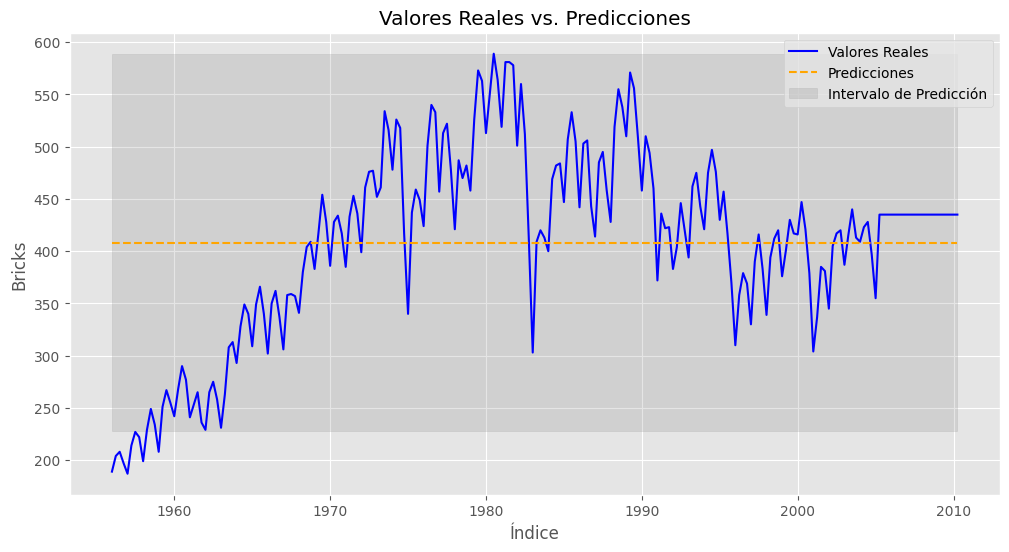

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bricks['Bricks'], label='Valores Reales', color='blue')
plt.plot(df_bricks['media_prediction'], label='Predicciones', color='orange', linestyle='dashed')
plt.fill_between(df_bricks.index, df_bricks['media_prediction'] - 1.96*df_bricks['Bricks'].std(),
                 df_bricks['media_prediction'] + 1.96*df_bricks['Bricks'].std(), color='gray', alpha=0.2, label='Intervalo de Predicción')
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Índice')
plt.ylabel('Bricks')
plt.legend()
plt.show()

$MSE$ y $R^2$

In [ ]:
# Calcular MSE y R²
mse = mean_squared_error(df_bricks['Bricks'], df_bricks['media_prediction'])
r2 = r2_score(df_bricks['Bricks'], df_bricks['media_prediction'])

print(f'MSE: {mse}')
print(f'R²: {r2}')

MSE: 8429.0877030553
R²: 0.0


Los resultados indican un MSE de 8429, lo que refleja que el modelo tiene una cantidad significativa de error en sus predicciones. Ademas, el valor de R² = 0 implica que el modelo no está explicando ninguna variabilidad en los datos, lo cual es preocupante para la calidad del ajuste. Los resultados de las metricas sugieren que el modelo no tiene capacidad predictiva, esto se debe a que todas las predicciones son la media y por eso el modelo no esta capturando la relacion entre las variables.







Visualizar la distribucion de los residuales

In [ ]:
# Calcular los residuales
residuals = df_bricks['Bricks'] - df_bricks['media_prediction']

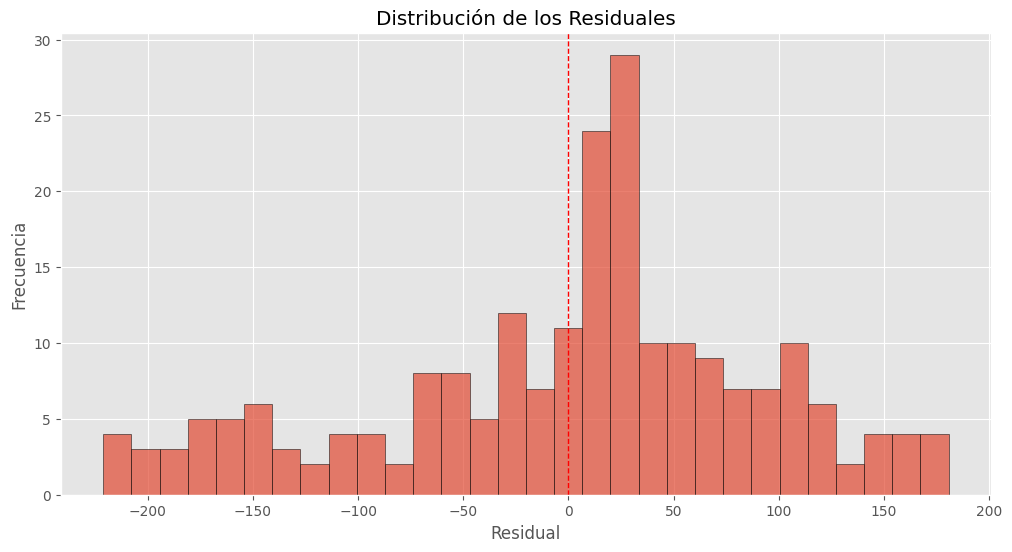

In [ ]:
# Visualizar la distribución de los residuales
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

Graficos de diagnostico:

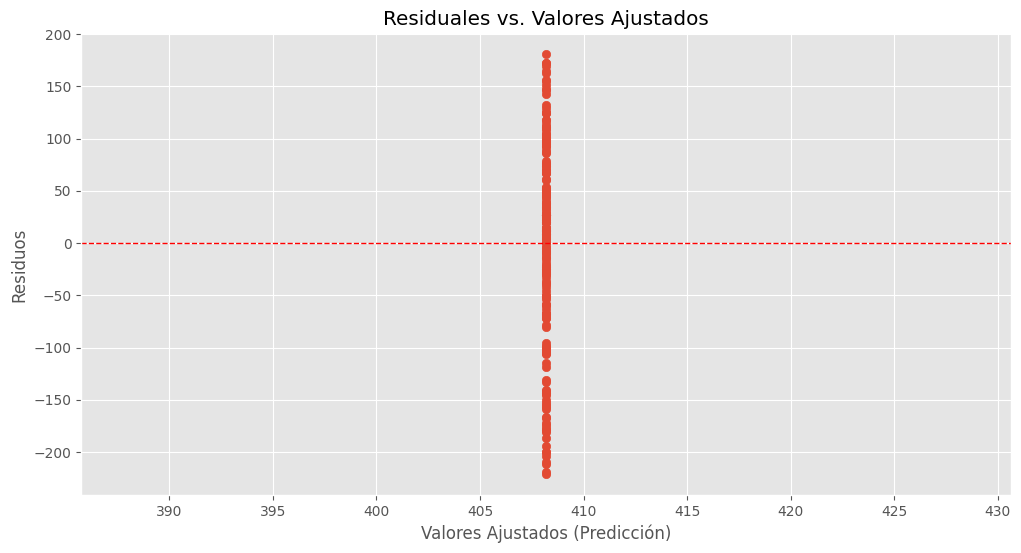

In [ ]:
#Residuales vs valores ajustos.
# Gráfico de Residuales vs Valores Ajustados
plt.figure(figsize=(12, 6))
plt.scatter(df_bricks['media_prediction'], residuals)
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residuales vs. Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicción)')
plt.ylabel('Residuos')
plt.show()

La grafica de *Residuales vs Valores ajustados* muestra una distribucion de puntos en la media lo que se describe como un patron e incumpliendo el principio de Homocedasticidad e indica que el modelo no es el adecuado.

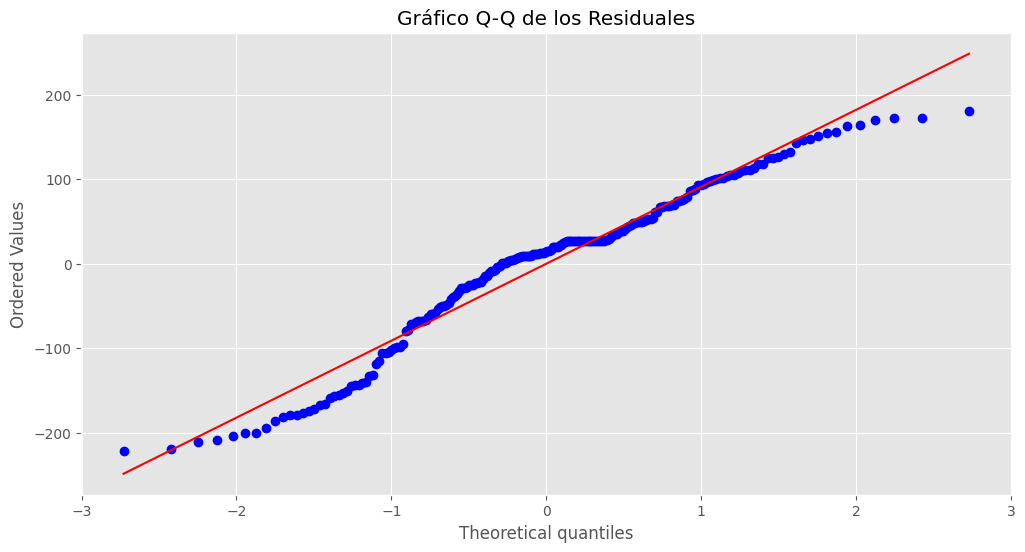

In [ ]:
# Grafico Q-Q
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de los Residuales')
plt.show()

La grafica muestra una distribucion de puntos alrededor de la linea lo que indica un comportamiento aproximadamente normal de los residuos pero con algunos datos alejados de la media.

In [ ]:
# Calcular los valores ajustados y la distancia de Cook
X = sm.add_constant(df_bricks['media_prediction'])
model = sm.OLS(df_bricks['Bricks'], X).fit()

<ipython-input-31-c8c727e92a2b>:9: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



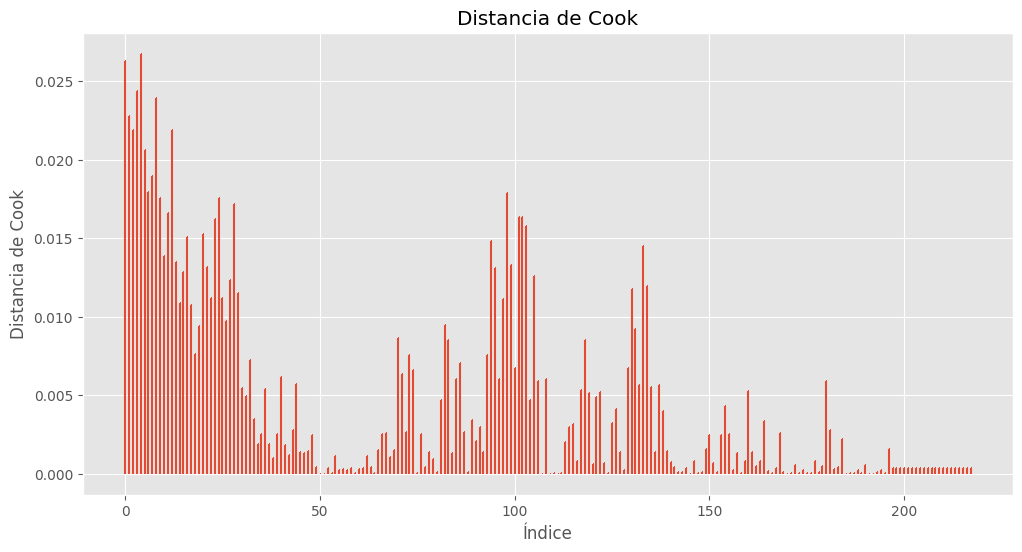

In [ ]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Gráfico de la distancia de Cook
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.title('Distancia de Cook')
plt.xlabel('Índice')
plt.ylabel('Distancia de Cook')
plt.show()

Las distancias de cook para el modelo representan en general un modelo que parece bueno, esto debido a que no existen tantos picos y muestran un modelo mas estable. Sin embargo la distancia mas alta esta alrededor de 0.025 lo que indica un valor muy bajo. Ademas cabe resaltar que dado todas las predicciones son la media y cada pico esta basado en los indices donde la media esta alejado al valor real.

##Construya un modelo para el cual toda predicción sea el punto inmediatamente anterior

In [ ]:
# Crear una nueva columna 'Prediction' que es igual al valor anterior de 'Bricks'
df_bricks['previous_prediction'] = df_bricks['Bricks'].shift(1)

# Asegurarse de que la primera fila sea NaN, ya que no hay un valor anterior
df_bricks['previous_prediction'].fillna(method='bfill', inplace=True)

<ipython-input-32-13247a830305>:5: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



- Visualizar los valores reales y las predicciones

In [ ]:
# Calcular el error estándar de las predicciones
error_std = df_bricks['Bricks'].std()

# Calcular el intervalo de predicción (Prediccion ± 1.96 * error estándar)
Lower_Bound = df_bricks['previous_prediction'] - 1.96 * error_std
Upper_Bound = df_bricks['previous_prediction'] + 1.96 * error_std

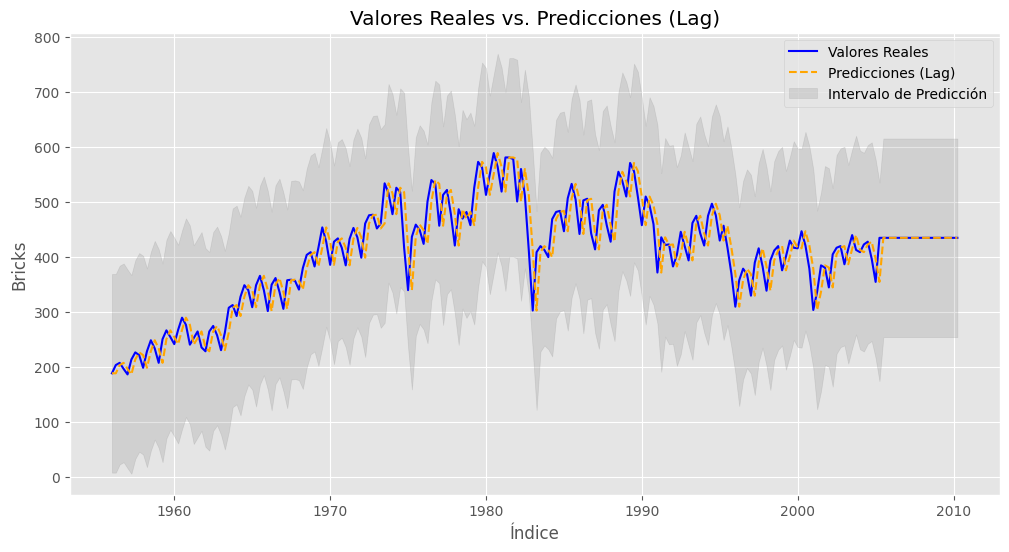

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bricks['Bricks'], label='Valores Reales', color='blue')
plt.plot(df_bricks['previous_prediction'], label='Predicciones (Lag)', color='orange', linestyle='dashed')
plt.fill_between(df_bricks.index, Lower_Bound,Upper_Bound, color='gray', alpha=0.2, label='Intervalo de Predicción')
plt.title('Valores Reales vs. Predicciones (Lag)')
plt.xlabel('Índice')
plt.ylabel('Bricks')
plt.legend()
plt.show()

- $MSE$  y  $R^2$

In [ ]:
mse = mean_squared_error(df_bricks['Bricks'][1:], df_bricks['previous_prediction'][1:])  # Excluyendo el primer valor NaN
r2 = r2_score(df_bricks['Bricks'][1:], df_bricks['previous_prediction'][1:])  # Excluyendo el primer valor NaN

print(f'MSE: {mse}')
print(f'R²: {r2}')

MSE: 1466.921658986175
R²: 0.8220939513162079


El valor de MSE y $R^2$ estan mostrando buenos resultados, indicando poco error por parte de las predicciones. Sin embargo, esto sucede porque los resultados del modelo al ser el valor anterior esta existiendo un sobre ajuste.

- Visualizar la distribucion de los residuales

In [ ]:
# Calcular los residuales
residuals = df_bricks['Bricks'] - df_bricks['previous_prediction']

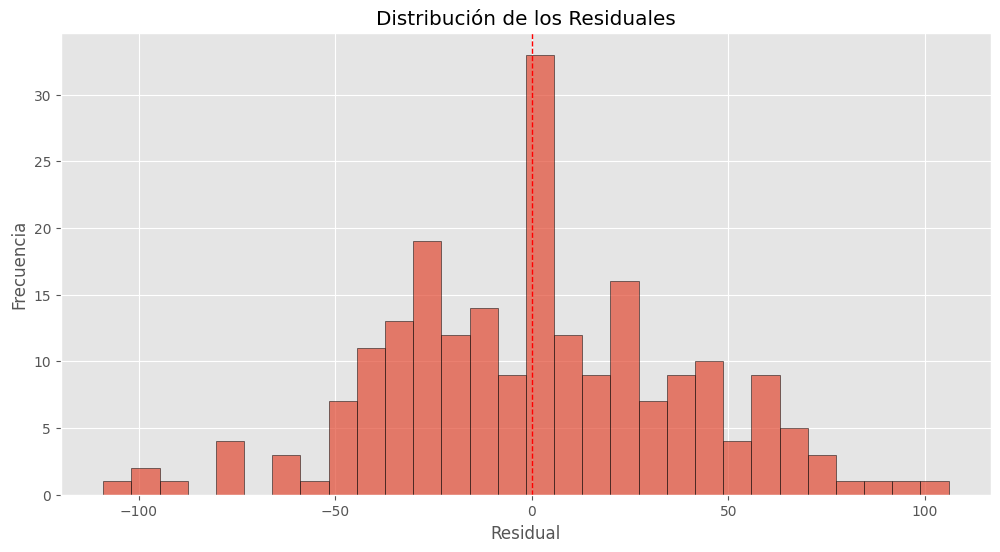

In [ ]:
# Visualizar la distribución de los residuales
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

- Graficos de diagnostico:

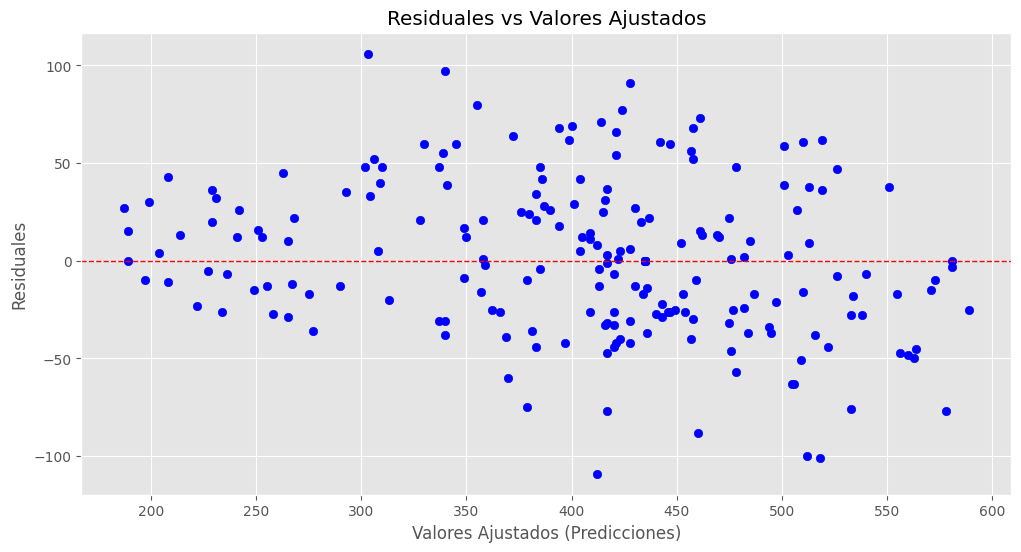

In [ ]:
# Gráfico de Residuales vs Valores Ajustados
plt.figure(figsize=(12, 6))
plt.scatter(df_bricks['previous_prediction'], residuals, color='blue')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residuales vs Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicciones)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

Los residuales parecen tener un comportamiento de homocedasticidad (Residuales distribuidos aleatoreamente alrededor de la linea) lo que indica que el modelo es bueno para realizar las predicciones. Sin embargo, esto sucede por el sobre ajuste del modelo.

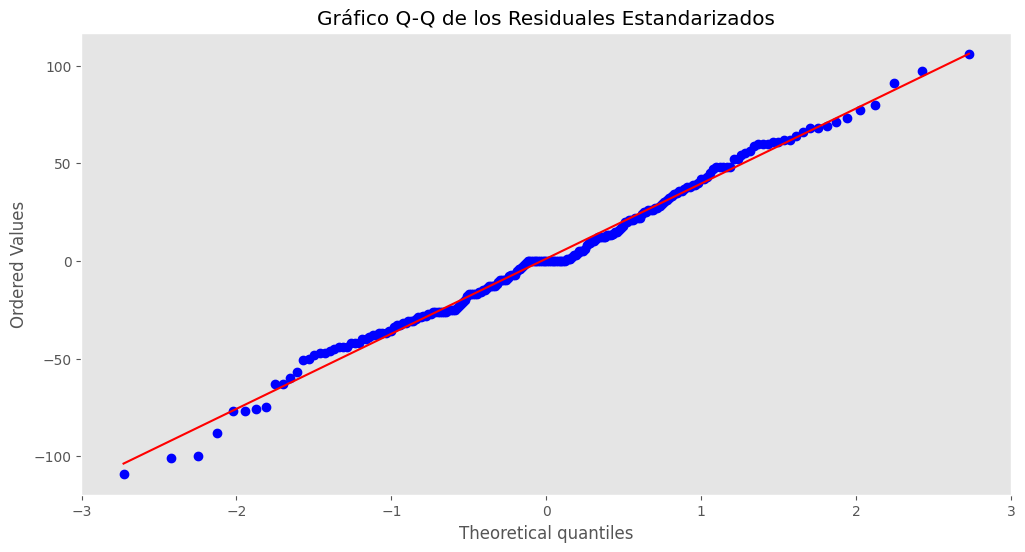

In [ ]:
#Gráfico Q-Q para comparar con una distribución normal
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de los Residuales Estandarizados')
plt.grid()
plt.show()

La grafica muestra un comportamiento normal de los residuales con ciertos valores atipicos.

In [ ]:
X = sm.add_constant(df_bricks['previous_prediction'])
model = sm.OLS(df_bricks['Bricks'], X).fit()

<ipython-input-39-97c1f3d07dfa>:10: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



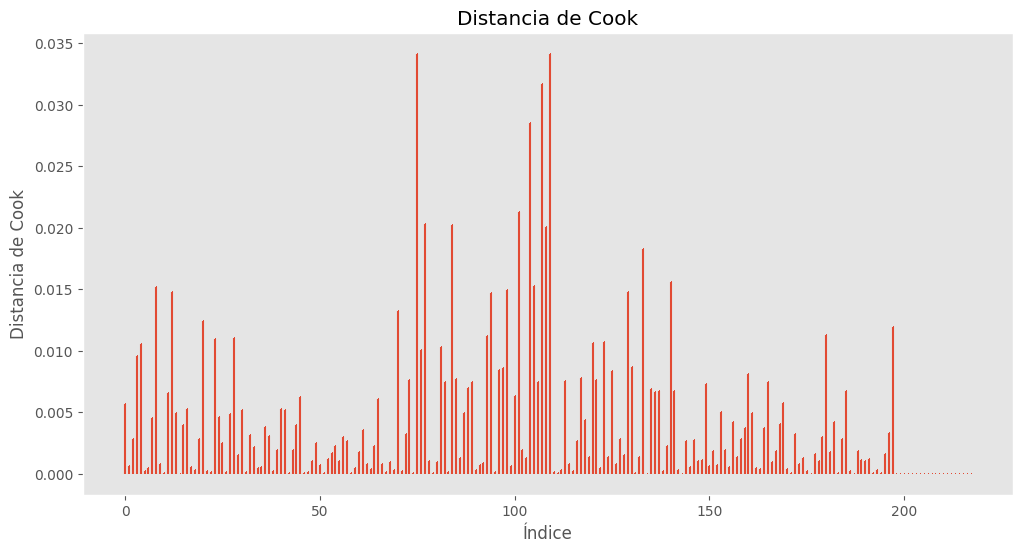

In [ ]:
# Calcular la distancia de Cook
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Graficar la distancia de Cook
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.title('Distancia de Cook')
plt.xlabel('Índice')
plt.ylabel('Distancia de Cook')
plt.grid()
plt.show()

La distancia de cook para cada dato muestra una buena estabilidad pero nuevamente esto esta sucediendo por el sobreajuste de los datos. Ademas, se pueden apreciar ciertos picos alrededor del indice 75 y el indice 100 lo que esta indicando que los datos al rededor de esos indices estan teniendo una mayor influencia sobre el modelo y por ende pueden resultar en datos atipicos.

##Determine la estacionalidad de la serie y construya un modelo para el cual toda predicción sea él valor de la serie en la estación inmediatamente anterior.


In [ ]:
# Graficar la serie de tiempo usando plotly.express
fig = px.line(df_bricks, x=df_bricks.index, y='Bricks', title='Serie de Tiempo de Bricks',
              labels={'Bricks': 'Bricks', 'Quarter': 'Fecha'})
fig.update_traces(mode='lines+markers')  # Para mostrar líneas y marcadores
fig.show()

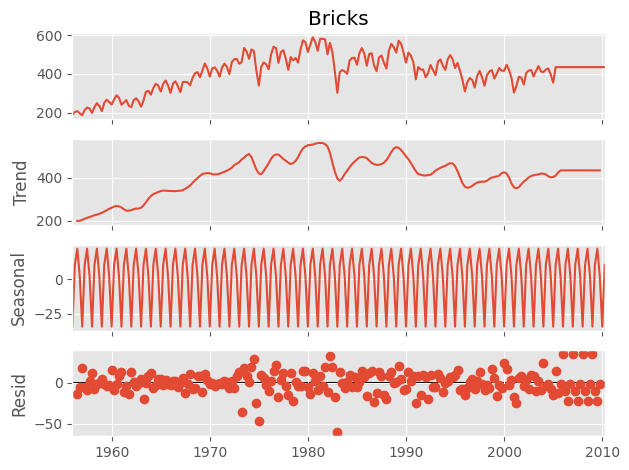

In [ ]:
# Descomposición estacional de la serie 'Bricks'
result = seasonal_decompose(df_bricks['Bricks'], model='additive', period=4)

# Graficar la descomposición
result.plot()
plt.show()

La estacionalidad en la serie de tiempo es trimestral (4 periodos)


In [ ]:
# Crear la columna de predicción estacional
df_bricks['stacional_prediction'] = df_bricks['Bricks'].shift(4)  # 4 trimestres antes

- Visualizar los valores reales y las predicciones

In [ ]:
# Calcular el error estándar de las predicciones
error_std = df_bricks['Bricks'].std()

# Calcular el intervalo de predicción (Prediccion ± 1.96 * error estándar)
Lower_Bound = df_bricks['stacional_prediction'] - 1.96 * error_std
Upper_Bound = df_bricks['stacional_prediction'] + 1.96 * error_std

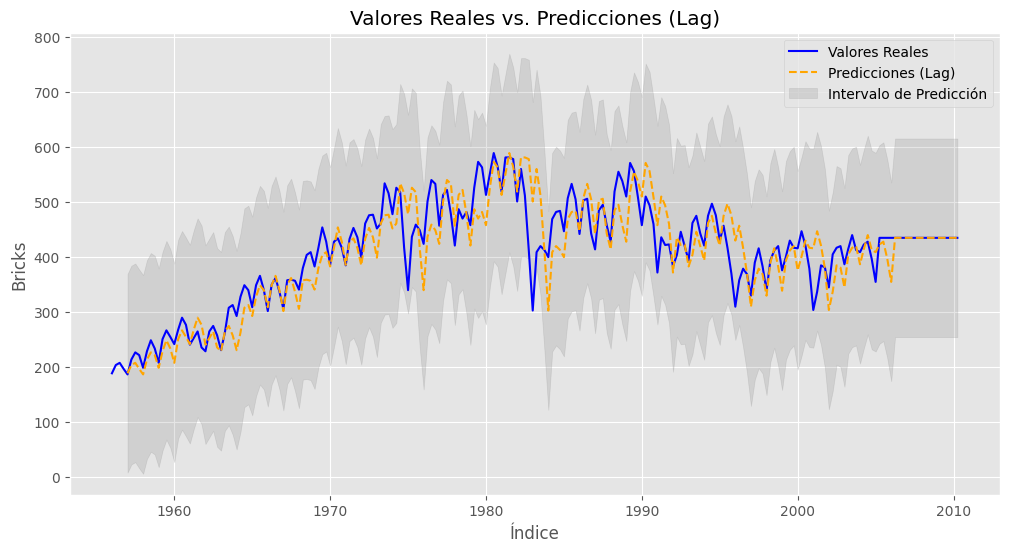

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bricks['Bricks'], label='Valores Reales', color='blue')
plt.plot(df_bricks['stacional_prediction'], label='Predicciones (Lag)', color='orange', linestyle='dashed')
plt.fill_between(df_bricks.index, Lower_Bound, Upper_Bound, color='gray', alpha=0.2, label='Intervalo de Predicción')
plt.title('Valores Reales vs. Predicciones (Lag)')
plt.xlabel('Índice')
plt.ylabel('Bricks')
plt.legend()
plt.show()

- $MSE$  y  $R^2$

In [ ]:
# Calcular MSE y R²
mse_stacional = mean_squared_error(df_bricks['Bricks'][4:], df_bricks['stacional_prediction'][4:])
r2_stacional = r2_score(df_bricks['Bricks'][4:], df_bricks['stacional_prediction'][4:])

print(f'MSE Estacional: {mse_stacional}')
print(f'R² Estacional: {r2_stacional}')

MSE Estacional: 2154.429906542056
R² Estacional: 0.7222350979388845


Al igual que el modelo anterior (Toda prediccion es el punto anterior), El MSE y $R^2$ muestran buenos resultados dado el ajuste de los datos. Sin embargo en este caso muestra se muestra una precision mas deficiente debido al periodo de prediccion en los datos.

- Visualizar la distribucion de los residuales


In [ ]:
# Calcular los residuales
residuals_stacional = df_bricks['Bricks'] - df_bricks['stacional_prediction']

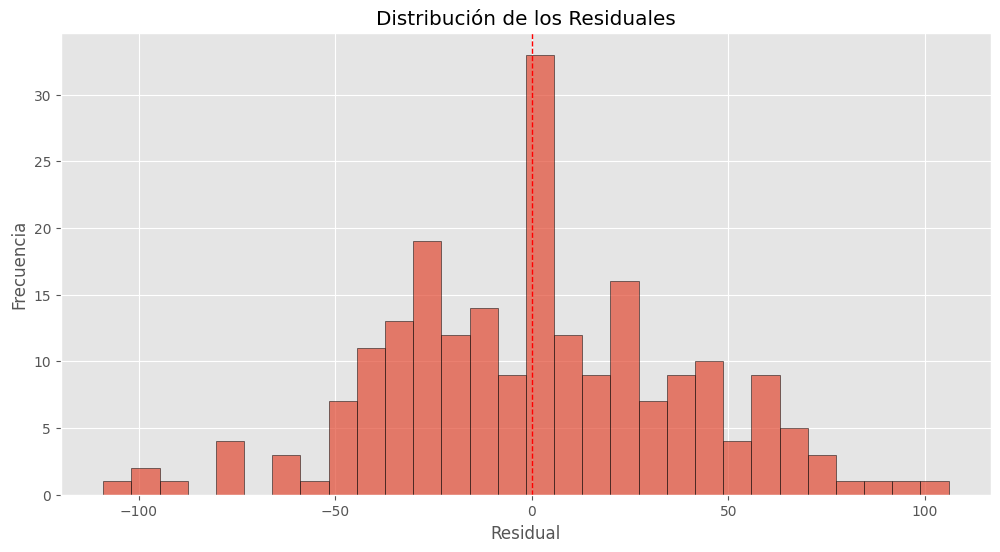

In [ ]:
# Visualizar la distribución de los residuales
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

- Graficos de diagnostico:

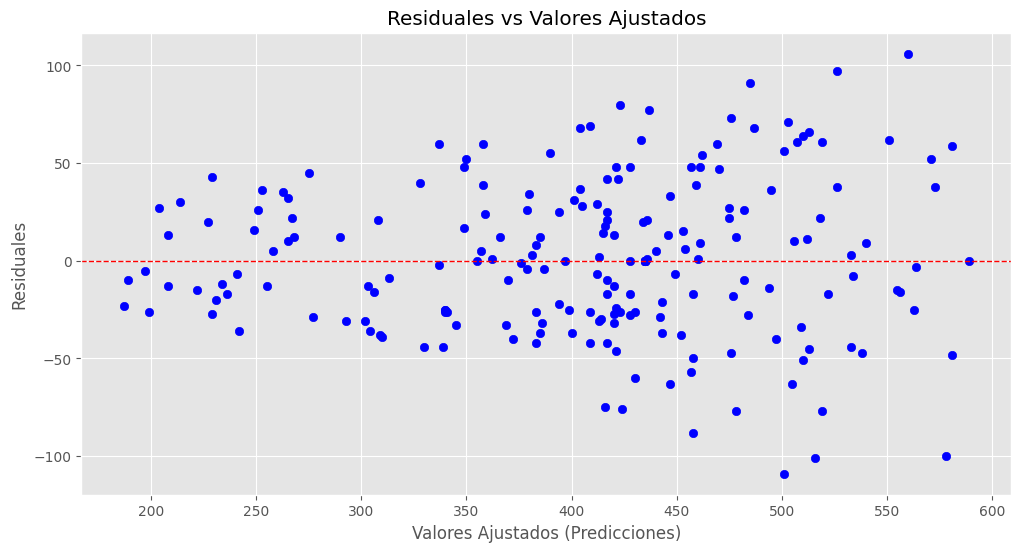

In [ ]:
# Gráfico de Residuales vs Valores Ajustados
plt.figure(figsize=(12, 6))
plt.scatter(df_bricks['stacional_prediction'], residuals, color='blue')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residuales vs Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicciones)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

La grafica muestra heterocedasticidad ya que se evidencia un patron de embudo, esto se debe a que los coeficientes del modelo estan sesgados y por ende da predicciones menos confiables.

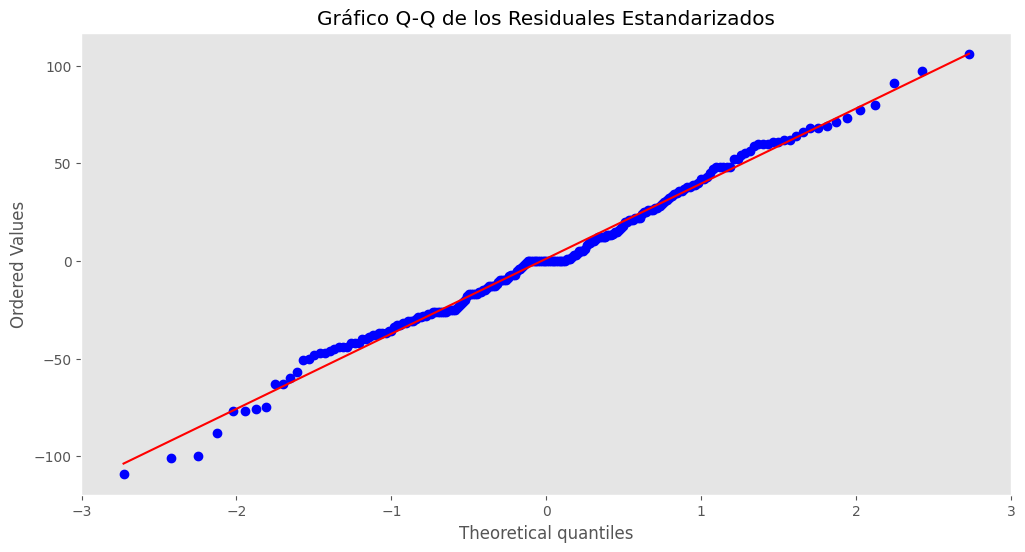

In [ ]:
#Gráfico Q-Q para comparar con una distribución normal
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de los Residuales Estandarizados')
plt.grid()
plt.show()

In [ ]:
# Crear un nuevo DataFrame solo con filas completas para ambas columnas,
df_bricks_cleaned = df_bricks.dropna(subset=['Bricks', 'stacional_prediction'])

# Definir X e y usando el DataFrame limpio
X = sm.add_constant(df_bricks_cleaned['stacional_prediction'])
y = df_bricks_cleaned['Bricks']

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()

<ipython-input-51-c3b4bc626694>:7: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



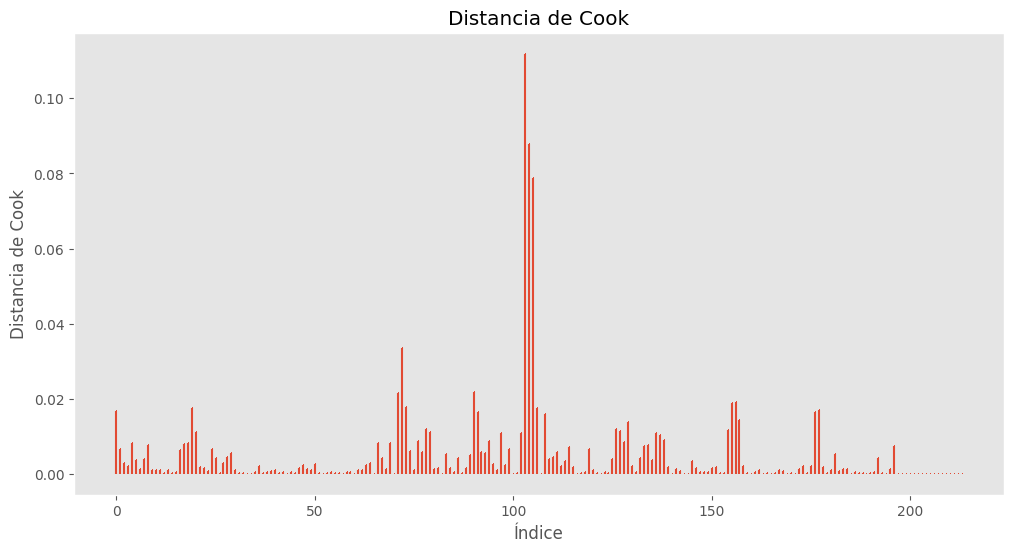

In [ ]:
# Calcular la distancia de Cook
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Graficar la distancia de Cook
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.title('Distancia de Cook')
plt.xlabel('Índice')
plt.ylabel('Distancia de Cook')
plt.grid()
plt.show()

Las distsancias de cook en este modelo estan indicando una influencia similar en la mayoria de los datos, con un pequeños outliers alrededor del indice 100. Esto indica que el modelo podria ser bueno dada la poca variabilidad de los residuales. Sin embargo, hay que resaltar que sigue siendo un modelo sobre ajustado por lo que las predicciones de los datos tienden a ser buenas.

##Ajuste un modelo de regresión lineal

In [ ]:
y = df_bricks['Bricks']
X = sm.add_constant(range(len(y)))  # Usar el índice como variable independiente

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()

In [ ]:
df_bricks['lineal_prediction'] = model.predict(sm.add_constant(range(len(y))))

- Visualizar los valores reales y las predicciones

In [ ]:
# Calcular el error estándar de las predicciones
error_std = df_bricks['Bricks'].std()

# Calcular el intervalo de predicción (Prediccion ± 1.96 * error estándar)
Lower_Bound = df_bricks['lineal_prediction'] - 1.96 * error_std
Upper_Bound = df_bricks['lineal_prediction'] + 1.96 * error_std

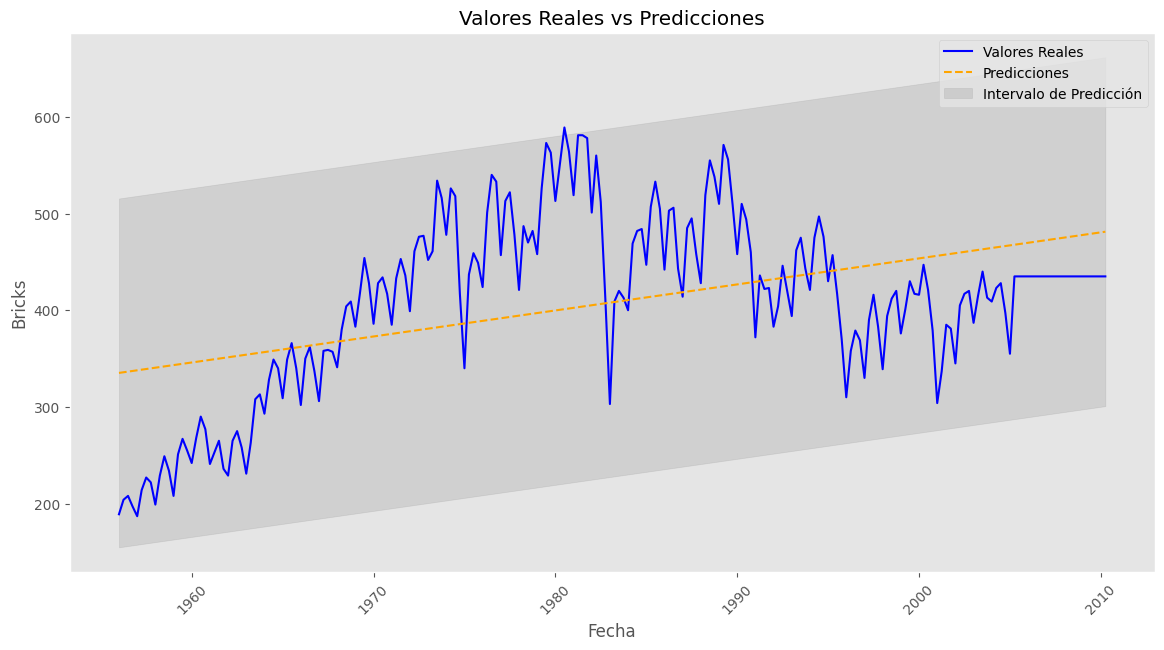

In [ ]:
# Graficar los valores reales y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_bricks.index, df_bricks['Bricks'], label='Valores Reales',color='blue')
plt.plot(df_bricks.index, df_bricks['lineal_prediction'], label='Predicciones', linestyle='--',color='orange')
plt.fill_between(df_bricks.index, Lower_Bound, Upper_Bound, color='gray', alpha=0.2, label='Intervalo de Predicción')
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Bricks')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

- $MSE$  y  $R^2$

In [ ]:
mse = mean_squared_error(df_bricks['Bricks'], df_bricks['lineal_prediction'])
r2 = r2_score(df_bricks['Bricks'], df_bricks['lineal_prediction'])

print(f'MSE: {mse}')
print(f'R²: {r2}')

MSE: 6635.919660653712
R²: 0.21273572011258302


Estos resultados sugieren que el modelo tiene un ajuste pobre y no capta bien las relaciones en los datos, esto se debe a la gran variabilidad que existe en los datos.

- Visualizar la distribucion de los residuales

In [ ]:
# Calcular los residuales
residuals = df_bricks['Bricks'] - df_bricks['lineal_prediction']

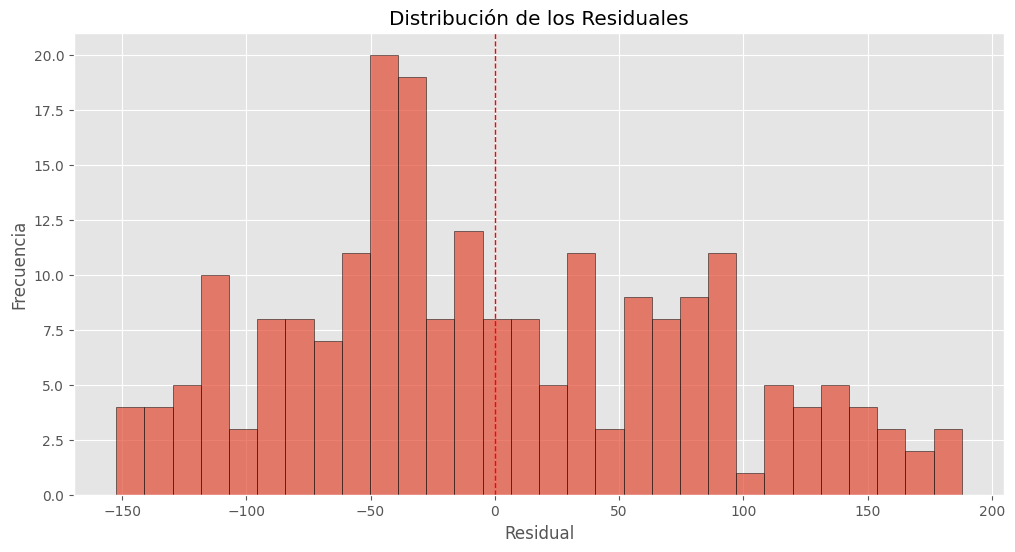

In [ ]:
# Visualizar la distribución de los residuales
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

- Graficos de diagnostico:

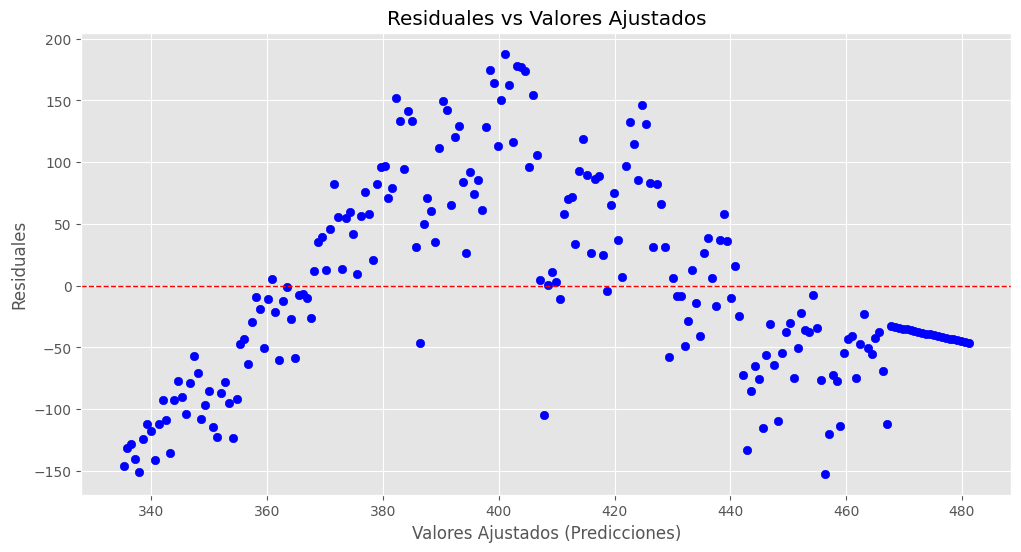

In [ ]:
# Gráfico de Residuales vs Valores Ajustados
plt.figure(figsize=(12, 6))
plt.scatter(df_bricks['lineal_prediction'], residuals, color='blue')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residuales vs Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicciones)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

La grafica demuestra que existe no linealidad en los residuos lo que esta indicando que un modelo lineal no es el mas adecuado para los datos.

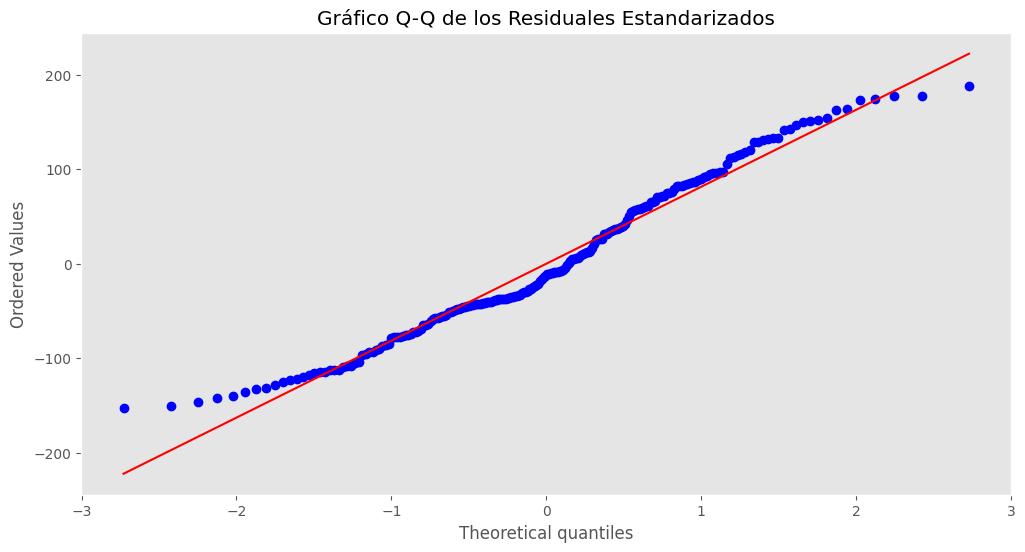

In [ ]:
#Gráfico Q-Q para comparar con una distribución normal
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de los Residuales Estandarizados')
plt.grid()
plt.show()

<ipython-input-61-66d634406d4d>:13: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



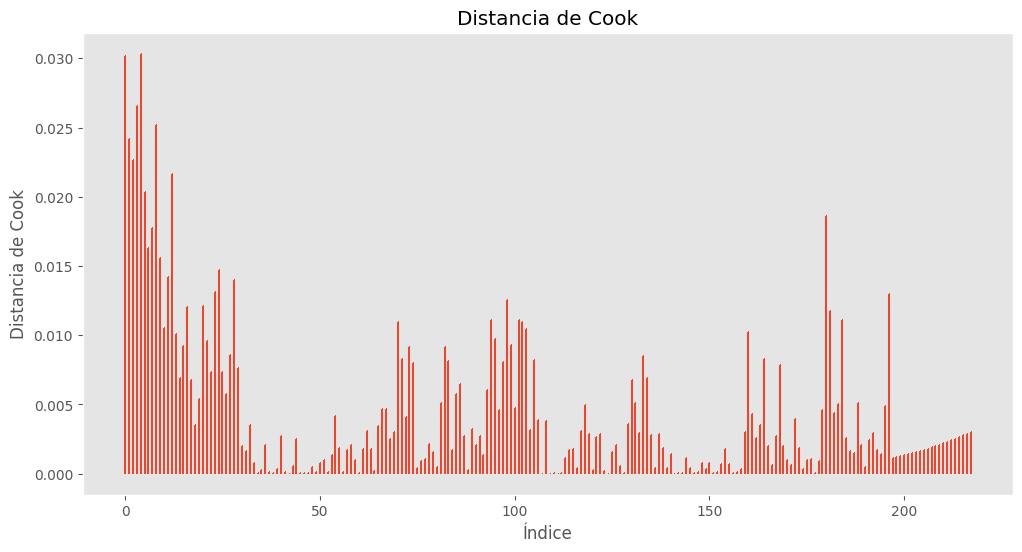

In [ ]:
# Definir X e y usando el DataFrame limpio
X = sm.add_constant(df_bricks['lineal_prediction'])
y = df_bricks['Bricks']

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()
# Calcular la distancia de Cook
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Graficar la distancia de Cook
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.title('Distancia de Cook')
plt.xlabel('Índice')
plt.ylabel('Distancia de Cook')
plt.grid()
plt.show()

Al igual que las predicciones con la media, en el modelo lineal se muestra una especia de estabilidad en los datos, pero con varios picos lo que significa que varios de los valores se podrian estar tomando como valores atipicos que estan influenciando mucho al modelo y por esto no se esta logrando una buena prediccion.

##Ajuste un modelo de regresión polinomial. Determine el grado del polinomio que a su criterio mejor se ajusta a los datos.

In [ ]:
# Crear un rango de índices como variable independiente
X = np.array(range(len(df_bricks))).reshape(-1, 1)

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

# Ajustar el modelo
model_poly = LinearRegression().fit(X_poly, df_bricks['Bricks'])

# Predecir usando el modelo polinomial
df_bricks['poly_prediction'] = model_poly.predict(X_poly)

- Visualizar los valores reales y las predicciones

In [ ]:
# Calcular el error estándar de las predicciones
error_std = df_bricks['Bricks'].std()

# Calcular el intervalo de predicción (Prediccion ± 1.96 * error estándar)
Lower_Bound = df_bricks['poly_prediction'] - 1.96 * error_std
Upper_Bound = df_bricks['poly_prediction'] + 1.96 * error_std

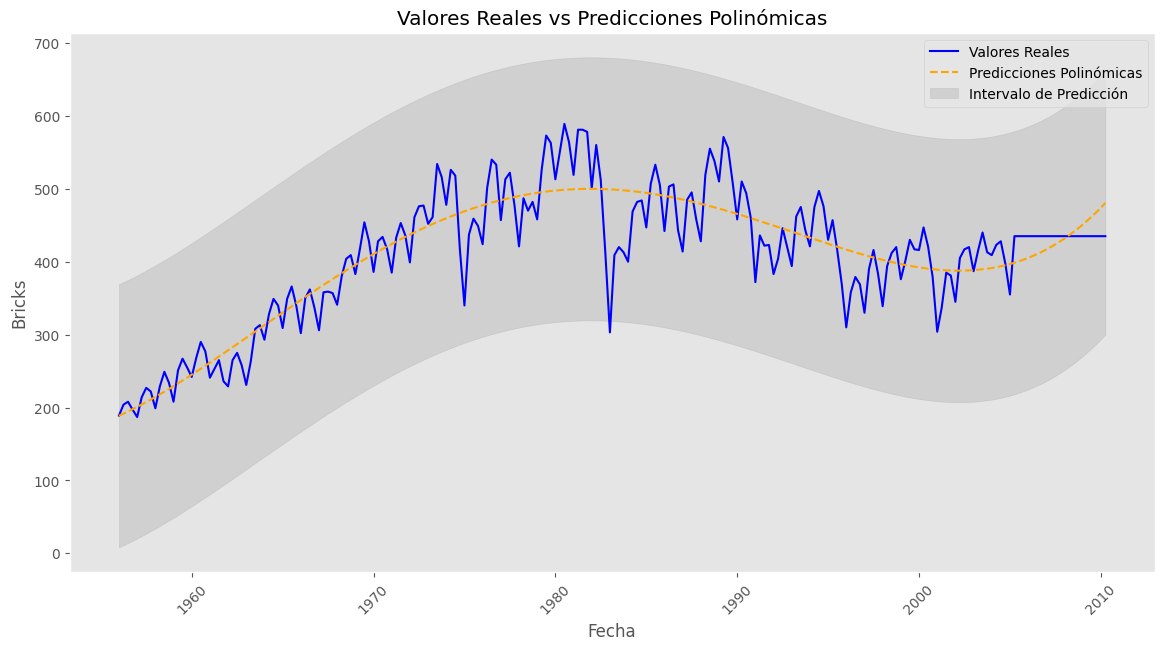

In [ ]:
# Graficar los valores reales y las predicciones del modelo polinomial
plt.figure(figsize=(14, 7))
plt.plot(df_bricks.index, df_bricks['Bricks'], label='Valores Reales', color='blue')
plt.plot(df_bricks.index, df_bricks['poly_prediction'], label='Predicciones Polinómicas', linestyle='--',color='orange')
plt.fill_between(df_bricks.index, Lower_Bound, Upper_Bound, color='gray', alpha=0.2, label='Intervalo de Predicción')
plt.title('Valores Reales vs Predicciones Polinómicas')
plt.xlabel('Fecha')
plt.ylabel('Bricks')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

El modelo polinomial elegido fue de grado 5. El criterio de eleccion se debe a la estacionalidad de los datos (4 periodos) y se le sumo un grado para ajustar un poco mas el modelo dado la variabilidad de los datos.

- $MSE$  y  $R^2$

In [ ]:
# Calcular MSE y R²
mse_poly = mean_squared_error(df_bricks['Bricks'], df_bricks['poly_prediction'])
r2_poly = r2_score(df_bricks['Bricks'], df_bricks['poly_prediction'])

print(f'MSE (Polinomial): {mse_poly}')
print(f'R² (Polinomial): {r2_poly}')

MSE (Polinomial): 1760.7281068263014
R² (Polinomial): 0.7911128500670258


Las métricas de rendimiento presentan resultados prometedores, ya que las predicciones del modelo son significativamente más cercanas a los valores reales. Además, aproximadamente el 80% de la variabilidad de los datos es explicada por el modelo, lo que indica que este captura adecuadamente la relación entre las variables, sin mostrar signos de sobreajuste.

- Visualizar la distribucion de los residuales

In [ ]:
# Calcular los residuales
residuals = df_bricks['Bricks'] - df_bricks['poly_prediction']

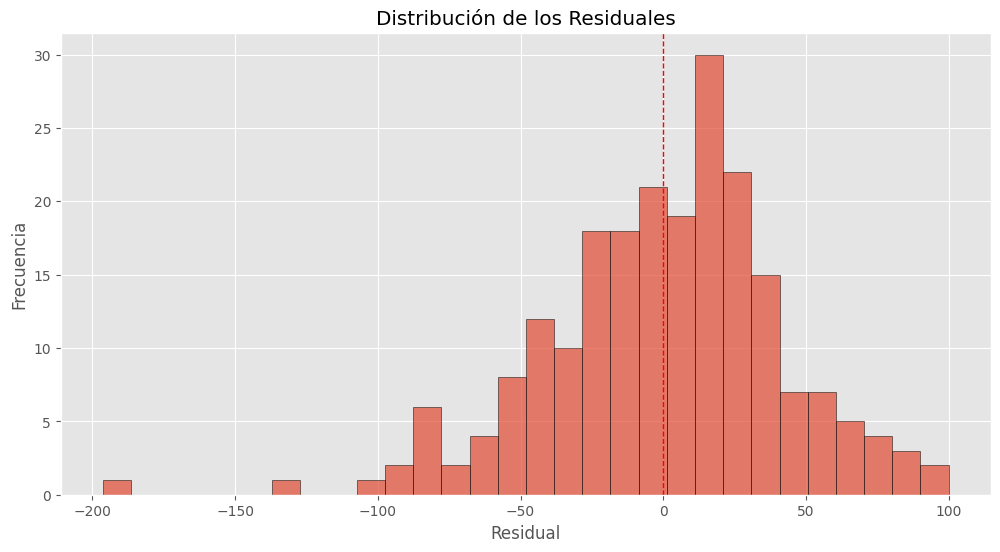

In [ ]:
# Visualizar la distribución de los residuales
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

- Graficos de diagnostico:


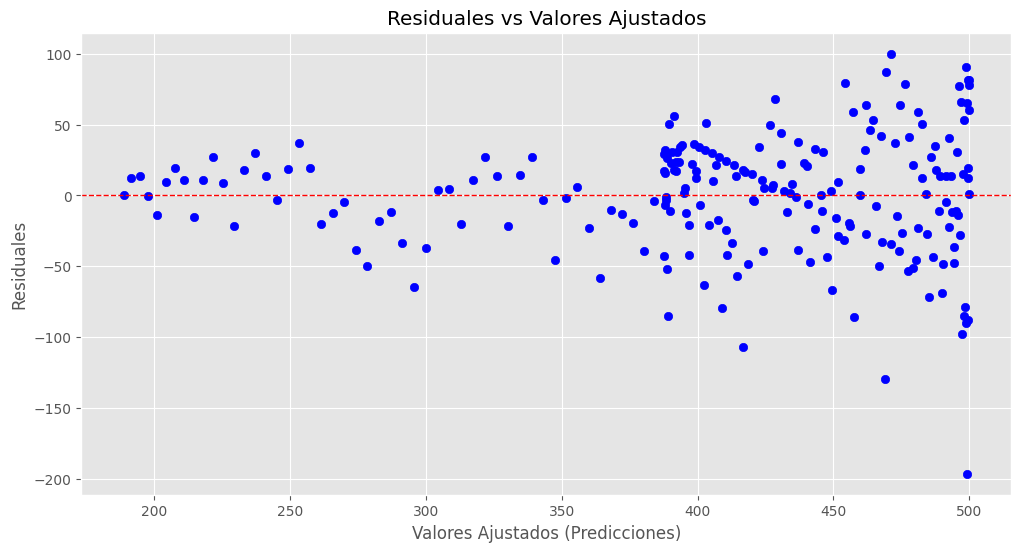

In [ ]:
# Gráfico de Residuales vs Valores Ajustados
plt.figure(figsize=(12, 6))
plt.scatter(df_bricks['poly_prediction'], residuals, color='blue')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residuales vs Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicciones)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

Un patron de Heterocedasticidad en forma de embudo esta indicando que para ciertos niveles de la variable dependiente, los errores de prediccion tienden a ser mas pequeños, mientras que para otros tienden a ser mas grandes. En este caso el embudo se abre a medida que los valores ajustados aumentan y por esto los errores tienden a crecer en estos valores.

Se puede notar que para los valores menores a 400 aproximadamente los valores estan la forma del embudo no es tan evidente, esto se debe a que en este rango la variabilidad de los datos no es pronunciable sin embargo a medida que pasamos un valor mayor a 400 en la variable dependiente la variabilidad es mayor y es aqui donde se comioenza a pronunciar el embudo, lo que indica que para predicciones en valores mayores la precision se pueden estar viendo afectas.


Esto no necesariamente esta proponiendo un mal modelo, solo esta evidenciando el error que tiene el modelo en la prediccion y proponiendo utilizar otro modelo que describa mejor los datos debido a que no se cumple el principio de homocedasticidad.

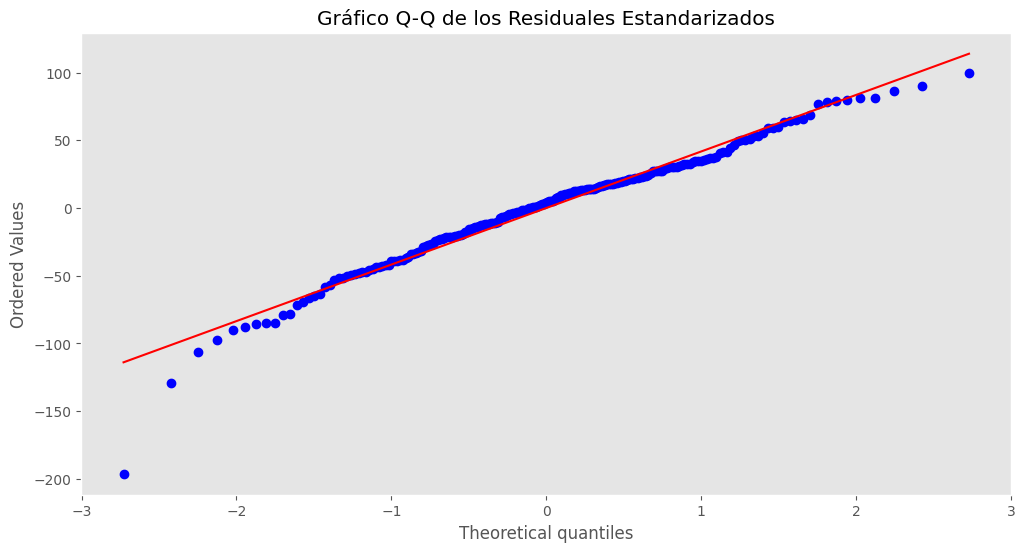

In [ ]:
#Gráfico Q-Q para comparar con una distribución normal
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de los Residuales Estandarizados')
plt.grid()
plt.show()

<ipython-input-69-134cc0577a32>:13: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



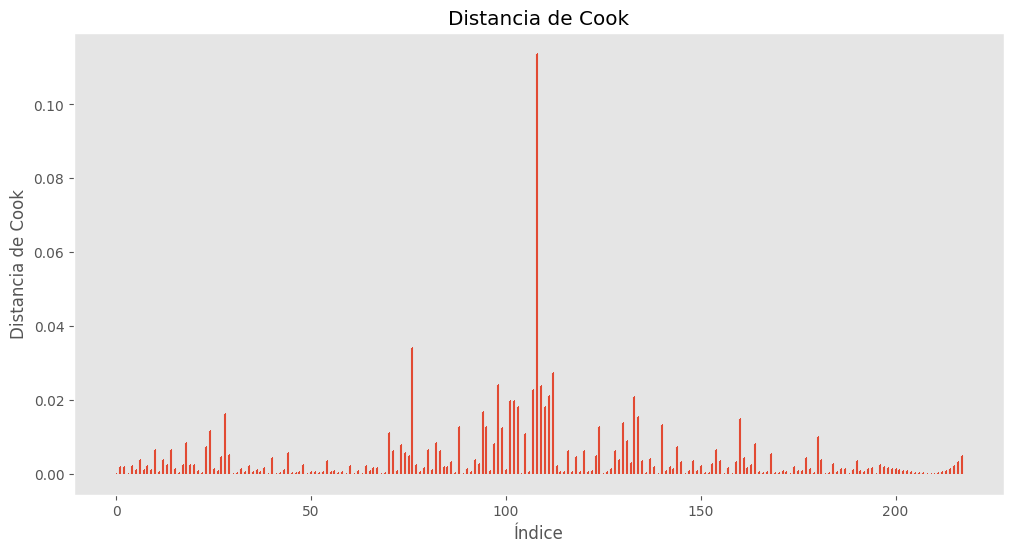

In [ ]:
# Definir X e y usando el DataFrame limpio
X = sm.add_constant(df_bricks['poly_prediction'])
y = df_bricks['Bricks']

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()
# Calcular la distancia de Cook
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Graficar la distancia de Cook
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.title('Distancia de Cook')
plt.xlabel('Índice')
plt.ylabel('Distancia de Cook')
plt.grid()
plt.show()

A pesar de que se observan picos aproximadamente en los índices 75 y 100, como en los modelos anteriores, en este caso se evidencia que cada pico se basa en un índice específico para cada valor aproximado, en lugar de un rango. Esto indica la presencia de valores atípicos en estos índices, pero, en general, el modelo es más estable.

#14. A partir de los resultados del punto anterior, seleccioné según su criterio cuál sería el mejor modelo. Tenga en cuenta los valores de MSE, el diagnóstico de residuales y el valor de R

- Los modelos basados en la media y de regresion lineal mostraron valores muy bajos en las metricas de rendimiento indicando malas predicciones para los datos. Ademas, estos modelos muestran una no linealidad o patron en los residuales por lo que no se consideran buenos modelos para el conjunto de datos.

- El modelo basado en la estacionalidad y el que utiliza el dato anterior de los datos reales muestran buenos resultados en las métricas; sin embargo, esto se debe al sobreajuste del modelo. Este sobreajuste se refleja en ciertos comportamientos o patrones visibles en el gráfico de residuales versus valores ajustados. Además, la distancia de Cook revela múltiples picos en los datos, lo que indica que, a pesar del sobreajuste, existen varios valores atípicos. Esto afecta al modelo, ya que estos puntos tienen una mayor influencia que otros, lo que puede conducir a malas predicciones.

- El modelo polinomial presenta los mejores resultados generales, explicando casi el 80% de la variabilidad en los datos. Aunque se observa el principio de heterocedasticidad en los residuales, este patrón refleja los numerosos cambios en los datos, lo que sugiere que hay un mayor error o variación en las predicciones para valores más altos. Es importante destacar que el principio de Cook indica un modelo más estable en comparación con los modelos anteriores, mostrando un solo pico pronunciado en un índice específico en lugar de en un rango de índices. Además, la distribución de los residuales exhibe la mejor normalidad en comparación con los demás modelos.

- Dada las anteriores conclusiones el mejor modelo para los datos es el polinomial de grado 5.